<center>
<h1 style="margin-bottom:0.5cm;font-size:40px;">TP Automatants</h1>
    

<div>
<img src="https://raw.githubusercontent.com/Automatants/projets-de-permanence/master/GAN/images/logo.png" width="200" style="padding-right: 55px;"/>
</div>
    
   
<h1 style="font-size:50px;margin-bottom:0.5cm;">Les GAN</h1>
    
   
<div>
<img src="https://raw.githubusercontent.com/Automatants/projets-de-permanence/master/GAN/images/DCGAN.png" width="700" style="padding-right: 50px;"/>
</div>
    
</center>

<div>
<img src="attachment:DCGAN.png" width="600" align="center" style="padding-right: 50px;"/>
</div>

## I. Rappels sur les GAN

### Principe général

**Ce TP ne présente pas les GAN dans le détail, mais rappelle quelques bases.**

Les GAN sont constitués de deux réseaux qui ont des objectifs contraires, ils sont adversaires.
Le premier réseau transforme du bruit en image, c'est le **générateur (G)**. Le deuxième réseau prend en entrée des images et les classe en deux catégories, en leur associant leur probabilité d'être issues de la base de données : c'est donc un classifieur binaire, il est appelé **discriminateur (D)**.

Le discriminateur est alimenté par des images de deux sources : il y a les images qui proviennent de la base de données (images réelles), et celles générées par le générateur. Le rôle du discriminateur sera donc de dire si une image est réelle ou générée. Il s'agit ensuite d'entraîner G afin qu'il maximise la probabilité que D fasse une erreur, et d'optimiser D pour qu'il améliore la justesse de sa classification.

Les GAN ont été inventés par Ian Goodfellow en 2014. Dans ce TP, on s'intéresse à la forme simple du GAN, mais il existe un nombre incalculable d'architectures plus complexes. On s'intéresse aussi dans un premier temps à un problème simplifié qui permettra de bien comprendre comment fonctionnent les GAN, et surtout pourquoi ils ne fonctionnent jamais comme prévu.

Pour rappel, la fonction de coût (**coût adversaire**) de G à minimiser est la suivante :

$$\begin{aligned}
\mathcal{L}_{\mathrm{DCGAN}}\left(G, D, p_{\mathrm{data}}, p_{\mathrm{bruit}}\right) &=
   \mathbb{E}_{x \sim p_{\mathrm{data}}}(\log (D(x))) + \mathbb{E}_{z \sim \mathrm{p_{bruit}}}(\log (1 - D(G(z)))
\end{aligned}$$

Dans le cadre de la théorie des jeux, un GAN correspond alors à un jeu à deux joueurs adversaires. La théorie des équilibres de Nash donne un unique état stable. Il correspond à un coût égal à $-\log 4$ pour G et $ \log 4$ pour D. Dans cette configuration, **le discriminateur est forcé d'associer une probabilité de 0.5 pour chaque image donnée en entrée**, le générateur étant devenu trop fort.

### Un peu de maths (seulement pour ceux qui aiment ça)

L'objectif d'un GAN - la génération d'images suivant un dataset - peut être formalisé comme un problème d'optimisation bayésienne. Nous cherchons à approcher la distribution $p_{\mathrm{data}}$ d'une variable aléatoire $X: \Omega \longrightarrow \mathcal{X}$. Pour ce faire, on se donne une famille paramétrique de distributions $\mathcal{M}_{\mathbb{R}^{d}} = \{p_{\theta}, \theta \in \mathbb{R}^d\}$, ainsi qu'un prior $p_{\mathrm{bruit}}(z)$ relatif à une variable aléatoire $Z : \Omega \longrightarrow \mathcal{Z}$. On détermine ensuite la distribution souhaitée à l'aide de la formule de Bayes. $$\begin{aligned} p(\theta | \mathrm{data}) \propto p_{\mathrm{bruit}}(z)p(\mathrm{data}|\theta)\end{aligned}$$

Comme il est impossible de résoudre directement la formule de Bayes, il nous faut défnir une fonction de côut qui mesure la distance entre $p_{\theta}$ et $p_{\mathrm{data}}$, puis employer des algorithmes de descente du gradient. La famille $\mathcal{M}_{\mathbb{R}^d}$ prend alors naturellement la forme d'un réseau de neurones, que l'on écrit $g : \mathcal{Z} \times \mathbb{R}^{d} \longrightarrow \mathcal{X}$, ou en notation condensée $g_{\theta}(z)$ .


Il reste à trouver une bonne métrique pour mesurer la distance entre $p_{\theta}$ et $p_{\mathrm{data}}$. Une telle métrique entre deux distributions de probabilité est appelée **divergence**, ou **distance statistique**.

#### I. [Divergence de Kullback-Leibler](https://en.wikipedia.org/wiki/Relative_entropy)

La divergence la plus classique en deep-learning est la divergence de Kullback-Leibler notée $D_{KL}$, aussi appelée **entropie relative**.
Elle s'écrit :
$$D_{\mathrm{KL}}(P \| Q)=\sum_{x \in \mathcal{X}} P(x) \log \left(\frac{P(x)}{Q(x)}\right)$$
Vous y voyez probablement un air de famille avec l'**entropie croisée** que vous utilisez pour la classification et c'est normal puisqu'elles sont cousines et que l'une s'écrit en fonction de l'autre.

#### II. [Divergence de Jensen-Shannon](https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence)

Le problème de $D_{KL}$ est qu'elle n'est pas symétrique. Or pour notre application, nous n'avons aucune raison de privilégier une distribution plutôt qu'une autre. Heureusement, on peut symétriser $D_{KL}$.

On définit donc la divergence de **Jensen-Shannon** : 

$$
\begin{array}{l}
\operatorname{D_{JS}}(P \| Q)=\frac{1}{2} D_{KL}(P \| M)+\frac{1}{2} D_{KL}(Q \| M) \\
\text { où } M=\frac{1}{2}(P+Q)
\end{array}$$

$D_{JS}$ a le même rôle que $D_{KL}$ mais a le bon goût d'être symétrique. C'est cette divergence qu'on utilise dans la version "classique" du GAN : **le DCGAN**.

#### Oui, mais quel rapport avec la fonction de coût adversaire proposée plus haut ?

Comme vu en formation, pour un G fixé, un discriminateur est optimal pour : $D_{G}^{*}(\boldsymbol{x})=\frac{p_{\text {data}}(\boldsymbol{x})}{p_{\text {data}}(\boldsymbol{x})+p_{g}(\boldsymbol{x})}$.

Donc le GAN optimal vérifie : $D_{G}^{*}(\boldsymbol{x})=\frac{1}{2}.$

Or, on peut montrer que : $\mathbb{E}_{\boldsymbol{x} \sim p_{\text {dua }}}\left[\log D_{G}^{*}(\boldsymbol{x})\right]+\mathbb{E}_{\boldsymbol{z} \sim p_{\boldsymbol{z}}}\left[\log \left(1-D_{G}^{*}(G(\boldsymbol{z}))\right)\right]$ se simplifie en  $ -\log 4 + 2 \mathrm{D{JS}}(p_{\mathrm{data}} || p_{\theta})$.

[Démonstration complète ici.](https://arxiv.org/pdf/1406.2661.pdf)

Finalement, on trouve que résoudre le problème avec la fonction de coût adversaire est équivalent à minimiser la divergence $D_{KL}$ entre $p_{\theta}$ et $p_{\mathrm{data}}$.

De tout ça, on doit retenir que le GAN optimal doit donner un côut de $-\log 4$ et que le discirinateur doit répondre au hasard : $D_{G}^{*}(\boldsymbol{x})=\frac{1}{2}.$
 


#### III. [Divergence de Wasserstein](https://en.wikipedia.org/wiki/Wasserstein_metric)

Une autre distance statistique très utile pour les GAN est la **distance de Wassertein** (ou **distance du terrassier**). Elle s'écrit :

$$W\left(\mathbb{P}_{r}, \mathbb{P}_{g}\right)=\inf _{\gamma \in \Pi\left(\mathbb{P}_{r}, \mathbb{P}_{g}\right)} \mathbb{E}_{(x, y) \sim \gamma}[\|x-y\|] \text { où } \Pi\left(\mathbb{P}_{r}, \mathbb{P}_{q}\right) \text { est l'ensemble des distributions jointes}$$

Elle se réécrit en :

$$W\left(p_{r}, p_{g}\right)=\frac{1}{K} \sup _{\|f\|_{L} \leq K} \mathbb{E}_{x \sim p_{r}}[f(x)]-\mathbb{E}_{x \sim p_{g}}[f(x)]$$

[Démonstration ici (perso je comprends rien)](https://arxiv.org/pdf/1701.07875.pdf)

Cette nouvelle forme en fait une métrique beaucoup plus sympathique à implémenter en pratique. La subtilité c'est que les fonctions que l'on cherche sont K-Lipschitziennes ${\|f\|_{L} \leq K}$, il faudra donc penser à appliquer une méthode de troncature ou une méthode de normalisation des poids du réseau [(la deuxième étant plus efficace)](https://linkcs.fr/user/2019darmounia) pour les forcer à respecter cette condition. [Plus de détails dans cet article passionnant.](https://arxiv.org/pdf/1704.00028.pdf)

Ce n'est pas évident en voyant la formule, mais elle a une signification physique assez intuitive. On ne rentrera pas dans les détails ici, les GAN de Wassertein feront probablement l'objet d'une formation à part entière. D'ici là, je vous invite à lire ce formidable article :

[**Why Wasserstein is better than JS or KL divergence?**](https://lilianweng.github.io/lil-log/2017/08/20/from-GAN-to-WGAN.html)


### Les problèmes classiques

De par leur caractères adversariaux, les GAN requièrent un équilibre fin entre le générateur et le discriminateur, ils sont donc par nature **instables**. L'étude de la convergence des GAN est un domaine encore très actif de la recherche. Il y a deux phénomènes qui rendent bien galère l'apprentissage des GAN : **l'effondrement des modes** (mode collapse), et la **non-convergence due à la perte d'équilibre du système**.

#### L'effondrement des modes

L'effondrement des modes survient quand le réseau générateur ne génère pas des images conformes à l'ensemble de la distribution des images réelles, mais seulement à une petite partie. C'est plus visible lorsque la distribution des images réelles forme des zones bien séparées, c'est-à-dire quand on a des classes bien définies. La manifestation du mode collapse donne des images générées qui se ressemblent toutes. Voilà quelques exemples de mode collapse (a priori vous aurez l'occasion d'en générer d'autres exemples par vous même, à votre grand désespoir).

Exemple de mode collapse sur MNIST :
![collapseA_1.png](https://raw.githubusercontent.com/Automatants/projets-de-permanence/master/GAN/images/collapseA_1.png)
![collapseA_2.png](https://raw.githubusercontent.com/Automatants/projets-de-permanence/master/GAN/images/collapseA_2.png)


Exemple de mode collapse sur CelebA, **ils ont tous le même visage** :
![collapseB_1.png](https://raw.githubusercontent.com/Automatants/projets-de-permanence/master/GAN/images/collapseB_1.png)
Pour comparaison, ce que ca devrait donner à ce stade de l'aprentissages :
![collapseB_2.png](https://raw.githubusercontent.com/Automatants/projets-de-permanence/master/GAN/images/collapseB_2.png)



Pour mieux comprendre ce qu'il se passe, on peut regarder la distribution des images de MNIST dans son ensemble. C'est possible grâce à des algorithmes de réduction de dimension.

> Attention, la réduction de dimension se fait dans l'espace des pixels, et non pas dans un espace sémantique. La visualisation ne permet donc pas de séparer efficacement les différentes classes, elle permet seulement un aperçu de la distribution dans l'espace sémantique.

On fait une réduction de dimension pour obtenir une représentation des espaces à 2 dimensions grâce à une réduction t-SNE.
Un premier exemple avec un effondrement sur deux modes :

![modes1.png](https://raw.githubusercontent.com/Automatants/projets-de-permanence/master/GAN/images/modes1.png)
![modes1_tsne.png](https://raw.githubusercontent.com/Automatants/projets-de-permanence/master/GAN/images/modes1_tsne.png)


Les points rouges correspondent aux images générées. Elles sont bien regroupées dans une petite zone. Ca montre que notre GAN n'approche pas la distribution des images dans son ensemble.

Un deuxième exemple avec un effondrement sur un seul mode, qui n'est pas un chiffre :

![modes2.png](https://raw.githubusercontent.com/Automatants/projets-de-permanence/master/GAN/images/modes2.png)
![modes2_tsne.png](https://raw.githubusercontent.com/Automatants/projets-de-permanence/master/GAN/images/modes2_tsne.png)


L'effondrement des modes peut avoir beaucoup de sources différentes. Notamment, un déséquilibre du nombre d'occurence des modes dans les données, un apprentissage trop rapide du discrinimateur, ou bien une spécialisation du générateur sur un mode en paticulier peuvent être des sources d'effondrement. Nous verrons ces cas dans la partie pratique du TP.


Il n'y a pas de solution simple, directe et universelle pour lutter contre l'effondrement des modes, mais quelques solutions ont été proposées :
- La pénalisation de la similarité des images en sortie de générateur *minibatch discrimination*. Cela consiste à ajouter un terme à la fonction de coût pour traduire la similarité (on peut par exemple calculer une similarité pixel à pixel, ou estimer la similarité sémantique à l'aide d'un autre réseau de neurones).
- Le **one-side label smoothing**. Cela consiste à changer l'objectif du discriminateur : son objectif ne sera plus de discriminer les fausses images avec une probabilité de 1, mais une probabilité plus faible, par exemple 0.9. Ca permet d'éviter la sur-confiance, et permet de laisser le générateur explorer tous l'espace des images possibles.
- Certaines architectures sont plus résistantes que d'autres à l'effondrement des modes. Par exemple, les GAN de Wasserstein ne font pas d'effondrement des modes. L'utilisation de la [normalisation spectrale](https://openaccess.thecvf.com/content_ICCV_2019/papers/Liu_Spectral_Regularization_for_Combating_Mode_Collapse_in_GANs_ICCV_2019_paper.pdf) est aussi un bon outil.
- Parfois un simple rééquilibrage des puissances du générateur et du discrinimateur suffisent pour donner une meilleure chance au générateur d'explorer les autres modes.

#### Perte de l'équilibre

Comme on le sait, l'apprentissage des GAN repose sur un équilibre fin entre le discriminateur et le générateur. Cet équilibre est parfois difficile à atteindre et est souvent instable, c'est pourquoi parfois (souvent en fait) le système s'effondre complètement.

Cet effondrement vient souvent du fait que le discriminateur est devenu trop fort (sa fonction de perte s'écroule), et le générateur ne peut plus s'améliorer. Lorsque cela arrive, l’entraînement peut être arrêté : les images générées ne s'amélioreront plus. 

Voilà un exemple de perte d'équilibre. La fonction de perte du discriminateur s'écroule et celle du générateur diverge :
![gifloss.gif](https://raw.githubusercontent.com/Automatants/projets-de-permanence/master/GAN/images/gifloss.gif)
![gifimages.gif](https://raw.githubusercontent.com/Automatants/projets-de-permanence/master/GAN/images/gifimages.gif)

Alors que l'apprentissage que l'on recherche ressemble plutôt à ca :

![lossgif.gif](https://raw.githubusercontent.com/Automatants/projets-de-permanence/master/GAN/images/lossgif.gif)

Il y a des solutions pour lutter contre ce problème. Ca consiste souvent à rééquilibrer les puissances ou les vitesses de convergence des différents réseaux. On peut par exemple diminuer la complexité du discriminateur, diminuer le taux d'apprentissage du discriminateur, ou mettre à jouer plus souvent le générateur que le discriminateur. Mais ça reste souvent assez compliqué de trouver le juste équilibre, c'est la difficulté majeure des GAN.

Ajouter du bruit sur les images de la base de données ou ajouter du label smoothing peut aussi améliorer la stabilité de l'apprentissage. Encore une fois, les GAN de Wasserstein sont plus stables que les GAN classiques, mais ne sont pas totalement immunisés contre le problème.

## II. Génération simple

Ca y est, on commence à coder !

On commence par entrainer un GAN sur un problème simplifié pour bien comprendre tous les mécanismes en jeu. Pour ça, on se créer nous même un dataset facile, avec trois types de courbes, que vous pouvez voir juste en dessous.


> Pour stocker les résultats, il faut un dossier vide `output` dans le même dossier que votre notebook.

### Créer la dataset

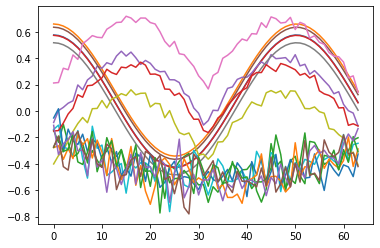

In [1]:
import numpy as np
from matplotlib import pyplot as plt

def f(x) :
    return -1+2*np.cos((x/30)+2)

def g(x) :
    return -1+2*abs(np.sin(x/10))

def h(x) :
    return -1+2*np.cos(x/8)

def get_example(n_examples, X, proba_last_mode):

    Y = np.zeros((n_examples, X.shape[0]))

    for i in range (n_examples) :
        p = np.random.uniform()
        if p < 0.3 :
            Y[i] = f(X)+np.random.normal(0, 0.4, X.shape)
        elif p < (1-proba_last_mode) :
            Y[i] = g(X)+np.random.uniform(-0.2, 0.2, X.shape)+np.random.normal()
        else :
            Y[i] = h(X)+np.random.uniform()
    return Y

def norm_example(X_examples):
    return (X_examples+1)/4
    
X = np.arange(0, 64, 1)
Y = norm_example(get_example(20, X, 0.4))

for i in range (16):
    plt.plot(X, Y[i])
plt.show()

### Le générateur

In [2]:
import tensorflow as tf

class Generator(tf.keras.Model):
    
  def __init__(self):
    super(Generator, self).__init__()
    self.dense0 = tf.keras.layers.Dense(32, use_bias=False, input_shape=(100,))
    self.acti0 = tf.keras.layers.ReLU()
    self.dense1 = tf.keras.layers.Dense(64, use_bias=False, activation='tanh')


  def call(self, x):
    x = self.dense0(x)
    x = self.acti0(x)
    x = self.dense1(x)
    return x

### Le discriminateur

In [3]:
import tensorflow as tf

class Discriminator(tf.keras.Model):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.dense0 = tf.keras.layers.Dense(64, use_bias=False, input_shape=(-1, 64))
    self.acti0 = tf.keras.layers.ReLU()
    self.dense1 = tf.keras.layers.Dense(1, use_bias=False, activation='sigmoid')
   
  def call(self, x):
    x = self.dense0(x)
    x = self.acti0(x)
    x = self.dense1(x)

    return x

### Les fonctions de coûts

In [4]:
import tensorflow as tf

def discriminator_loss(real_output, fake_output):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    real_loss = cross_entropy(tf.ones_like(real_output)-0.1, real_output) #One-sided label smoothing
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss+fake_loss
    return total_loss

def generator_loss(fake_output):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss_MSE(real_output, fake_output): 
    real_loss = tf.keras.losses.MSE(tf.ones_like(real_output)-0.1, real_output)
    fake_loss = tf.keras.losses.MSE(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss+fake_loss
    return tf.reduce_mean(total_loss)

def generator_loss_MSE(fake_output):
    return  tf.reduce_mean(tf.keras.losses.MSE(tf.ones_like(fake_output), fake_output))

### Le buffer

In [5]:
class Buffer :

  def __init__(self, recycle_div=2):
    self.recycle_div = recycle_div
    self.pool = []

  def update (self, generated_images):
    old_images = rd.sample(self.pool, min(len(self.pool), len(generated_images))//self.recycle_div)
    new_images = rd.sample(generated_images, len(generated_images)-len(old_images))
    self.pool = old_images+new_images
    return self.pool

### Bruit

In [6]:
import tensorflow as tf

def noise_fct (noise_shape) :
    if NOISE == "normal" :
        return tf.random.normal([noise_shape, NOISE_DIM], 0, 1)
    elif NOISE == "uniform" :
        return tf.random.uniform([noise_shape, NOISE_DIM], -1, 1)
    else :
        print("bruit inconnu")

### Train step

In [7]:
def train_step(images, buffer, on_generator, on_discriminator):
    
    noise = noise_fct (images.shape[0])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
      generated_images = generator(noise)
      generated_images = tf.reshape(generated_images, (-1, 64))

      jugement_images = np.array(buffer.update (generated_images.numpy().tolist()))
        
      real_output = discriminator(images)
      fake_output_generator = discriminator(generated_images)
      fake_output = discriminator(jugement_images)

      real_jugement = tf.reduce_mean(real_output)
      fake_jugement = tf.reduce_mean(fake_output_generator)

      gen_loss = generator_loss_MSE(fake_output_generator)
      disc_loss = discriminator_loss_MSE(real_output, fake_output)

      if on_generator :
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

      if on_discriminator :
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_jugement, fake_jugement


### Affichage

In [8]:
def generate_and_save_jugement(X, Lreal_jug, Lfake_jug, epoch):

    fig = plt.figure(figsize=(4,4))
    plt.plot(X,Lreal_jug, label = 'decisions on real')
    plt.plot(X,Lfake_jug, label = 'decisions on fake')
    plt.legend()
    
    plt.savefig('output/decisions.png')
    plt.show()

    plt.clf()
    plt.cla()
    plt.close()


def generate_and_save_plots(X, Lgen_loss, Ldisc_loss, epoch):

    fig = plt.figure(figsize=(4,4))
    plt.plot(X,Lgen_loss, label = 'gen_loss')
    plt.plot(X,Ldisc_loss, label = 'disc_loss')
    plt.legend()
    
    plt.savefig('output/losses.png')
    plt.show()

    plt.clf()
    plt.cla()
    plt.close()
    

def generate_and_save_images(model, epoch, test_input):

    predictions = model(test_input)

    if len(predictions.shape) <= 2 :
      print("affichage courbe")
      Xfunc = np.arange(0, 64, 1)
      fig = plt.figure(figsize=(8,8))
      for i in range(predictions.shape[0]):
          axes = plt.subplot(4, 4, i+1)
          axes.set_ylim([-1.2,1.2])
          plt.plot(Xfunc, predictions[i])
          plt.axis('off')

    else : 
      print("affichage image")
      fig = plt.figure(figsize=(4,4))
      for i in range(predictions.shape[0]):
          plt.subplot(4, 4, i+1)
          plt.imshow(255*(predictions[i, :, :, 0]+1)/2,  cmap='gray', vmin=0, vmax=255)
          plt.axis('off')
  
    plt.savefig('output/generations_'+str(epoch).zfill(4)+'.png')
    plt.show()
    
    plt.clf()
    plt.cla()
    plt.close()

### Apprentissage

In [9]:
def train(taille_dataset, epochs, proba_last):

  Xfunc = np.arange(0, 64, 1)
  Lgen_loss = []
  Ldisc_loss = []
  Lreal_jug = []
  Lfake_jug = []

  X = []
  j = 0
  buffer = Buffer(recycle_div=2)

  for epoch in range(epochs):
    start = time.time()
    
    for i in range(taille_dataset):
        j += 1
        
        image_batch = norm_example(get_example(BATCH_SIZE, Xfunc, proba_last))
        gen_loss, disc_loss, real_jugement, fake_jugement = train_step(image_batch, buffer, on_generator=True, on_discriminator=True)

        X.append(j)
        Lgen_loss.append(gen_loss)
        Ldisc_loss.append(disc_loss)
        Lreal_jug.append(real_jugement)
        Lfake_jug.append(fake_jugement)
    
    clear_output(wait=False)
    generate_and_save_plots(X, Lgen_loss, Ldisc_loss,  epoch+1)
    generate_and_save_jugement(X, Lreal_jug, Lfake_jug,  epoch+1)
    generate_and_save_images(generator, epoch + 1, seed)
    
    print ('Time for epoch {} is {} sec'.format(epoch + 1, round(time.time()-start, 2)))

### Génération

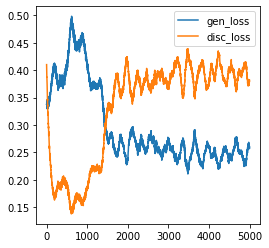

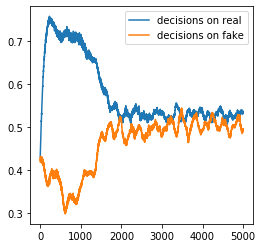

affichage courbe


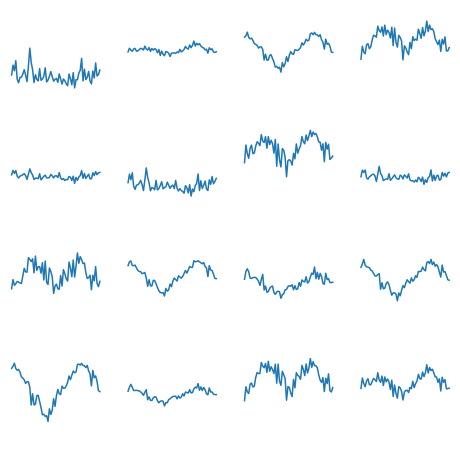

Time for epoch 100 is 2.39 sec


In [10]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import time
from keras.datasets import mnist
from keras.utils import np_utils
from matplotlib import pyplot as plt
import numpy as np
import random as rd
import os
from IPython.display import clear_output

print("Version de tf (>2.0) : ",tf.__version__)

tf.config.experimental_run_functions_eagerly(True)

generator = Generator()
discriminator = Discriminator()

generator_optimizer = tf.keras.optimizers.Adam(0.0002)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0002)

EPOCHS = 100
NOISE = "normal"
NOISE_DIM = 100
NB_EXAMPLES = 16
BATCH_SIZE = 512
PROBA_LAST_MODE = 0.4

seed = noise_fct (NB_EXAMPLES)

train(taille_dataset = 50, epochs = EPOCHS, proba_last=PROBA_LAST_MODE)

## III.Les problèmes classiques

### Effondrement des modes

##### Par déséquilibre des modes

On va déséquilibrer le nombre d'images par mode dans la base de données.

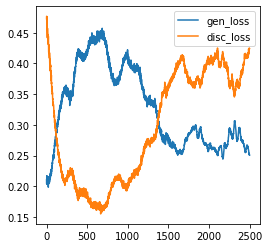

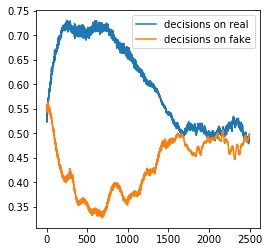

affichage courbe


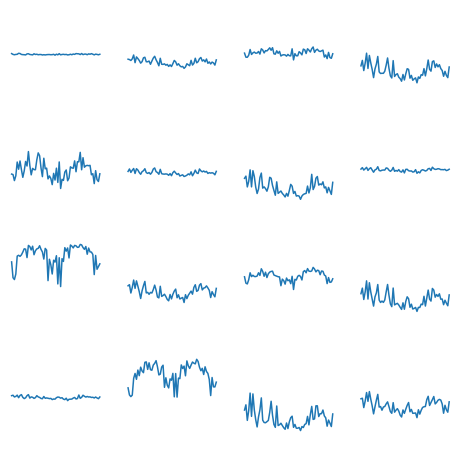

Time for epoch 50 is 2.48 sec


In [11]:
generator = Generator()
discriminator = Discriminator()

generator_optimizer = tf.keras.optimizers.Adam(0.0002)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0002)

EPOCHS = 50
NOISE = "normal"
NOISE_DIM = 100
NB_EXAMPLES = 16
BATCH_SIZE = 512
PROBA_LAST_MODE = 0.1

seed = noise_fct (NB_EXAMPLES)

train(taille_dataset = 50, epochs = EPOCHS, proba_last=PROBA_LAST_MODE)

Le fait de diminuer le nombre d'occurences du troisème mode le fait disparaitre de la distribution générée, alors même que 1 exemple sur 10 de la base de données correspond à ce mode. Il faudra donc faire attention lorsque vous utiliserez des GANs, un léger déséquilibre des modes peut avoir des grandes conséquences.

##### Par spécialisation du générateur

Dans cet exemple on provoque volontairement le déséquilibre des réseaux en augmentant fortement de taux d'apprentissage du discriminteur.

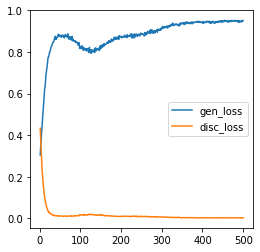

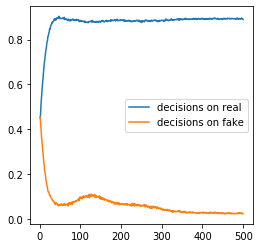

affichage courbe


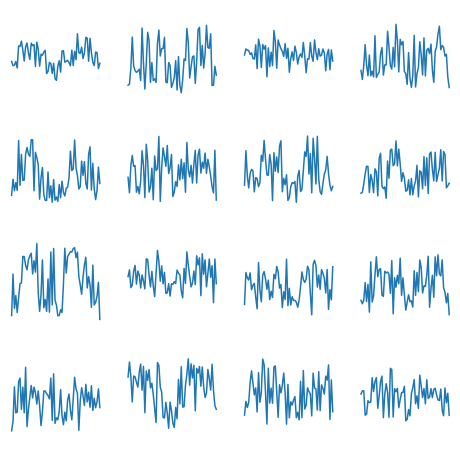

Time for epoch 10 is 2.42 sec


In [12]:
generator = Generator()
discriminator = Discriminator()

generator_optimizer = tf.keras.optimizers.Adam(0.0002)

#Changement : 
#discriminator_optimizer = tf.keras.optimizers.Adam(0.0002)
discriminator_optimizer = tf.keras.optimizers.Adam(0.002)

EPOCHS = 10
NOISE = "normal"
NOISE_DIM = 100
NB_EXAMPLES = 16
BATCH_SIZE = 512
PROBA_LAST_MODE = 0.4

seed = noise_fct (NB_EXAMPLES)

train(taille_dataset = 50, epochs = EPOCHS, proba_last=PROBA_LAST_MODE)

On observe que l'apprentissage reste bloqué sur un seul mode. Sauriez vous expliquer pourquoi ?

**Réponse :**
Dans un apprentissage classique, le générateur doit "tatônner" et "explorer" l'espace en générant des vecteurs aléatoires. Lorsqu'il a trouvé une zone (ie. une forme de courbe ici) qui permet de tromper le discriminateur, il sait que cela correspond à un mode de la base de données.
Or ici, le discriminateur devient très vite bien meilleur que le générateur. Donc quand le générateur trouve un nouveau mode le discrimateur n'est pas trompé, et le générateur abandonne directement ce mode. Cela pousse le générateur à se spécialiser sur les seuls modes qu'il a trouvé avant que le discrinimateur ne soit devenu trop bon.
C'est pour ça qu'ici le générateur se concentre sur un seul mode, qui est le mode le plus "facile" car le plus proche de l'aléatoire.


Ce deuxième effondrement est dû à une perte d'équilibre du système. Mais la perte d'équilibre est un problème à part entière, qui peut avoir des conséquences beaucoup plus graves sur l'apprentissage qu'un simple effondrement. C'est ce que nous allons voir dans la partie suivante.


[**Question pour ceux qui veulent :** Vous pouvez étudier l'influence du one-sided-label-smoothing sur l'effondrement.]

### Pertes d'équilibre

Dans cette partie, c'est à vous de jouer pour provoquer une perte d'équilibre du GAN.

Essayer à tour de rôle de :
  - rajouter des couches denses supplémentaires entre dense0 et dense1 dans le discriminateur (n'oubliez pas leurs activations)
  - rajouter des couches denses supplémentaires dans le générateur (n'oubliez pas leurs activations)
  - augmenter le taux d'apprentissage du discriminateur
  - changer des hyper-paramètres qui vous semblent intéressants
  
  
  
#### Attention si vous modifiez tout en même temps vous ne verrez pas les effets de chacun des changements. Pensez à réexécuter les cellules non modifiées pour annuler les changements avant de passer aux essais suivants.
    
Dans les deux premiers cas, vous devriez obtenir un déséquilibre du système. En changeant quelques hyper-paramètres, vous verrez que certains ont aussi une grande influence sur l'équilibre.

Notez que ce problème est simple et très stable. Sur des données réelles, un moindes changement pourra déséquilibrer le système et trouver le bon équilibre sera le fruit d'un grand nombre d'entrainement. Il s'agira d'observer qui du discriminateur ou du générateur prend le dessus, et de diminuer/augmenter leur puissance pour les équilibrer.

#### Modifiez les paramètres et la structure :

In [13]:
import tensorflow as tf

class Discriminator(tf.keras.Model):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.dense0 = tf.keras.layers.Dense(64, use_bias=False, input_shape=(-1, 64))
    self.acti0 = tf.keras.layers.ReLU()
    self.dense1 = tf.keras.layers.Dense(1, use_bias=False, activation='sigmoid')
   

  def call(self, x):
    x = self.dense0(x)
    x = self.acti0(x)
    x = self.dense1(x)

    return x

In [16]:
import tensorflow as tf

class Generator(tf.keras.Model):
    
  def __init__(self):
    super(Generator, self).__init__()
    self.dense0 = tf.keras.layers.Dense(32, use_bias=False, input_shape=(100,))
    self.acti0 = tf.keras.layers.ReLU()    
    self.dense1 = tf.keras.layers.Dense(64, use_bias=False, activation='tanh')


  def call(self, x):
    x = self.dense0(x)
    x = self.acti0(x)
    x = self.dense1(x)
    return x

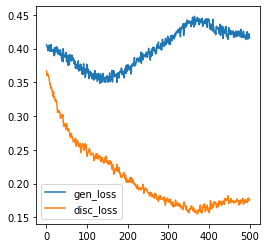

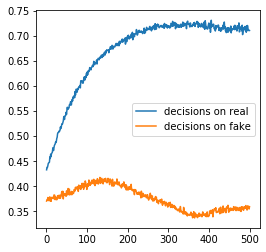

affichage courbe


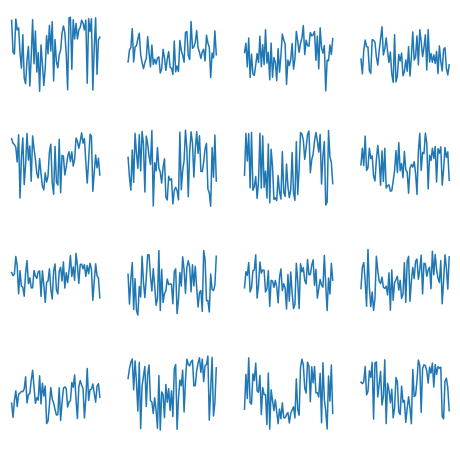

Time for epoch 10 is 2.78 sec


In [17]:
generator = Generator()
discriminator = Discriminator()

generator_optimizer = tf.keras.optimizers.Adam(0.0002)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0002)

EPOCHS = 10
NOISE = "normal"
NOISE_DIM = 100
NB_EXAMPLES = 16
BATCH_SIZE = 512
MAX_BUFFER_SIZE = 512
PROBA_LAST_MODE = 0.4

seed = noise_fct (NB_EXAMPLES)

train(taille_dataset = 50, epochs = EPOCHS, proba_last=PROBA_LAST_MODE)

#### Dans des conditions réelles il est important de ne jamais arrêter un GAN trop vite. Les GAN peuvent passer beaucoup de temps à générer n'importe quoi avant de subitement donner de bonnes images.

<strong> Les seules bonnes raisons d'arrêter un aprentissage sont : 
1. Le coût du discrinimateur qui tombe et reste à 0 (perte d'équilibre).
    
2. Des images générées de moins en moins bonnes sur une longue période.
    
3. Des images et coûts inchangés sur une longue période.
    
Sinon, il y a encore un espoir. </strong>

## IV. Génération de chiffres

#### A vous de jouer !

L'idée est de recréer un réseau comme au dessus adapté à la génération de chiffres. La plupart des cellules sont réutilisables, mais les réseaux et les hyper-paramètres changeront.

#### Attention. Pensez à réexécuter les cellules non modifiées pour annuler les changements avant de passer aux essais suivants.

### Importation des données

In [18]:
def get_data (batch_size, nb_train, nb_test) :

  mnist = tf.keras.datasets.mnist

  (x_train, y_train), (x_test, y_test) = mnist.load_data()

  x_train = x_train[:nb_train]
  y_train = y_train[:nb_train]
  x_test = x_test[:nb_test]
  y_test = y_test[:nb_test]

  x_train, x_test = (x_train.reshape(nb_train, 28, 28).astype(np.float32)-(255/2)) / 255.0, (x_test.reshape(nb_test, 28, 28).astype(np.float32)-(255/2)) / 255.0

  # nécessaire pour créer un objet Dataset
  x_train = x_train[..., tf.newaxis]
  x_test = x_test[..., tf.newaxis]

  train_ds = tf.data.Dataset.from_tensor_slices((x_train)).shuffle(10000).batch(batch_size)
  test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

  return train_ds, test_ds

### Indices :
**Comme régler un GAN prend parfois des heures, je vous donne une structure de réseau qui fonctionne.** Mais rien ne vous empêche de la changer.



**Generateur :**

```python
Dense(7*7, use_bias=False, input_shape=(100,))
ReLU()
Reshape((7, 7, 1))
#shape 7x7

Conv2DTranspose(512, (5, 5), strides=(1, 1), padding='same', use_bias=False)
BatchNormalization()
ReLU()
#shape 7x7

Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False)
BatchNormalization()
ReLU()
#shape 14x14

Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False,activation='tanh')
#shape 28*28
```
    
    
**Discriminateur :**

```python
Conv2D(64, (5,5), strides = (2, 2), padding='same', input_shape = (28, 28, 1))
LeakyReLU()
Dropout(0.2)

Conv2D(128, (5,5), strides = (2, 2), padding='same')
BatchNormalization()
LeakyReLU()
Dropout(0.2)

Flatten()
Dense(1)
LeakyReLU()

```

**Hyper-paramètres :**

```python
EPOCHS = 100
NOISE = "normal"
NOISE_DIM = 100
BATCH_SIZE = 512
MAX_BUFFER_SIZE = 512
nb_train, nb_test = 20000, 10000
```

In [19]:
#inserer ici votre nouveau GAN
#vous pouvez appeler certaines cellules au-dessus, et copier-coller ici celles que vous allez modifier

## Génération de visages

**Cette partie n'est pas facile et prend du temps**.

### Avertissement

Cette partie demande un travail de préparation des données, notamment pour gérer le changement de taille des images.

Elle va demander un temps de calcul assez conséquent. L'idéal est d'avoir accès à un ordinateur fixe qui peut tourner quelques heures, ou même une nuit.

Le set de données est aussi assez conséquente, il faut un peu de place disponible.

### Importation des données

Vous pouvez utiliser différentes banques d'images pour faire votre entrainement. Je vous conseille CelebA.

> CelebaA est proposée par l'Université de HongKong et est [disponible ici](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). Les images sont en très grande résolution, donc à moins que vous ayez accès à des grandes puissances de calcul, je vous conseille de réduire la taille de vos images. Dans la suite nous prendrons des images de (80, 64, 3). *Si vous avez des difficulté à réduire la taille des images, contactez les 2A*.

> **Attention, celebA est hyper biaisé.** Ce ne sont que des célébrités, donc des gens blancs (et beaux), peu de lunettes, etc. Ce n'est pas un dataset qui peut être utilisé pour des applications sérieuses.


Dans la suite, nous considérerons que vous avez des images de celebA, de (80, 64, 3), dans un dossier `/celeb_resize_80_64` qui ont les noms de base de celebA, cest-à-dire : `<id à 6 chiffres>.jpg`.

In [20]:
def get_data (batch_size, nb_train, nb_test) :

  direct = "/home/user/chemin/vers/data/celeb_resize_80_64/"
  files = [direct+str(i).zfill(6)+".jpg" for i in range (1, nb_train)]

  filenames = tf.constant(files)
  dataset = tf.data.Dataset.from_tensor_slices((filenames))

  def _parse_function(filename):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.cast(image_decoded, tf.float32)
    image = (image-(255/2))/255
    return image

  dataset = dataset.map(_parse_function)
  train_ds = dataset.batch(batch_size)

  return train_ds

### Aides

**Generateur :**

```python
Dense(3*10*8, use_bias=False, input_shape=(100,))
ReLU()

Reshape((10, 8, 3))

Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False)
BatchNormalization()
ReLU()
#shape 20x16

Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)
BatchNormalization()
ReLU()
#shape 40x32

Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
#shape 80*64
```
    
    
**Discriminateur :**

```python
Conv2D(64, (5,5), strides = (2, 2), padding='same', input_shape = (80, 64, 3))

LeakyReLU()
Dropout(0.2)

Conv2D(128, (5,5), strides = (2, 2), padding='same')
BatchNormalization()
LeakyReLU()
Dropout(0.2)

Conv2D(256, (5,5), strides = (1, 1), padding='same')
BatchNormalization()
LeakyReLU()
Dropout(0.2)

Flatten()
Dense(1)
LeakyReLU()
```

**Hyper-paramètres :**

```python
epochs = 500
noise_dim = 100
batch_size =  64
nb_train, nb_test = 60000, 10000
bruit = 'normal'
```
et 
```python
ng = 5
nd = 1
```
Tels que `on_generator=not i%ng` et `on_discriminator=not i%nd` dans les paramètres de `train_step()` (avec i le numéro de l'étape).
Cela permet d'entrainer plus souvent le dicriminateur que le générateur.

In [21]:
#inserer ici votre nouveau GAN
#vous pouvez appeler certaines cellules au-dessus, et copier-coller ici celles que vous allez modifier

## VI. D'autres GAN

Il existe beaucoup d'autres type de GAN que vous avez probablement abordé en formation. Voilà une petite liste de quelques architectures connues ou intéressantes :
- 1er article sur les GAN : https://arxiv.org/pdf/1406.2661.pdf
- DCGAN : https://arxiv.org/pdf/1511.06434.pdf (celui que l'on a utilisé)
- Wassertein GAN : https://arxiv.org/pdf/1701.07875.pdf
- conditional GAN : https://arxiv.org/pdf/1411.1784.pdf
- cycleGAN : https://arxiv.org/pdf/1703.10593.pdf
- styleGAN : https://arxiv.org/pdf/1812.04948.pdf
- text-2-image : https://arxiv.org/pdf/1605.05396.pdf

## FIN